In [9]:
from pyntcloud import PyntCloud 
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import sys
import pdb
from pcdiff import knn_graph
import jax
import jax.numpy as jnp
from jax import jit
from numpy import linalg as LA
import torch

In [10]:
def L2norm_nbh(data, comparison_size, origin_index=0):
    # Convert PyTorch tensor to JAX array if needed
    if isinstance(data, torch.Tensor):
        data = jax.device_put(data.detach().cpu().numpy())  # Convert to JAX arrayee

    data_jax = jnp.array(data)[:, 1:comparison_size+1, :]  # Ensure JAX array

    # Select the origin point from each batch (shape: (batch_size, num_features))
    origin = jnp.array(data)[:, origin_index, :]

    # Compute L2 norm for each row in the neighborhood (shape: (batch_size, num_neighbors))
    dist = jnp.linalg.norm(data_jax - origin[:, None, :], axis=2)

    return dist  # Shape: (batch_size, num_neighbors)

In [50]:
def Edge_and_Plane(path, edge_k = 10, plane_overlap = 6, edge_thresh = 0.06, plane_thresh = 0.001, plane_deviation = 0.0001, min_planesize = 20):
    # Load the XYZ file as a DataFrame
    df = pd.read_csv(path, sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])
    df["row_index"] = df.index
    # Convert DataFrame to a PyntCloud object
    pc = PyntCloud(df)
    x = pc.points['x'].values.reshape(-1,1)
    y = pc.points['y'].values.reshape(-1,1)
    z = pc.points['z'].values.reshape(-1,1)
    pc_array = np.hstack((x,y,z))

    tree = pc.add_structure("kdtree")
    nbh_curv = pc.get_neighbors(k=edge_k, kdtree=tree) 
    eigen_curv = pc.add_scalar_field("eigen_values", k_neighbors=nbh_curv)
    curvfield = pc.add_scalar_field("curvature", ev = eigen_curv)
    curvature = pc.points['curvature('+str(edge_k+1)+')'].values

    tree = pc.add_structure("kdtree")
    nbh_omni = pc.get_neighbors(k=min_planesize, kdtree=tree) 
    eigen_omni = pc.add_scalar_field("eigen_values", k_neighbors=nbh_omni)
    omnivarfield = pc.add_scalar_field("omnivariance", ev = eigen_omni)
    omnivaraiance = pc.points['omnivariance('+str(min_planesize+1)+')'].values

    nbh_origin = np.hstack((pc.points['row_index'].values.reshape(-1,1), nbh_curv))
    
    plane_deviation = np.mean(L2norm_nbh(pc_array[nbh_origin,:],5)) * plane_deviation

    plane_size = min_planesize

    while plane_size >= min_planesize:
        plane_field = pc.add_scalar_field("plane_fit", max_dist=plane_deviation, max_iterations=500)
        plane = pc.points['is_plane'].values.reshape(-1,1)
        plane_size = np.sum(plane[:,0], axis=0)
        
        if plane_size >= min_planesize:
            row_indicies = pc.points['row_index'].values.reshape(-1,1)
            plane_col = np.zeros_like(x)
            plane_col[row_indicies[np.where(plane == 1)[0]]] = 1
            pc_array = np.hstack((pc_array,plane_col))
            pc.points = pc.points[pc.points['is_plane'] != 1]

    if pc_array.shape[1] == 3:
        pc_array = np.hstack((pc_array, np.zeros_like(x).reshape(-1,1)))

    num_planes = len(pc_array[0,3:])
    plane_count = np.count_nonzero(np.sum(pc_array[nbh_origin[:,:plane_overlap],3:], axis=1), axis=1)
    edge_index = np.where((plane_count > 1) | (curvature >= edge_thresh))[0]
    edges = np.zeros_like(x)
    edges[edge_index,0] = 1

    plane_index = np.where(((plane_count == 1) | (omnivaraiance <= plane_thresh)) & (edges[:,0] != 1))[0]
    planes = np.zeros_like(x)
    planes[plane_index,0] = 1
    return edges, planes

In [6]:
def Scalar_fields(path, k = 50):
    df = pd.read_csv(path, sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])
    df["row_index"] = df.index
    pc = PyntCloud(df)
    x = pc.points['x'].values.reshape(-1,1)
    y = pc.points['y'].values.reshape(-1,1)
    z = pc.points['z'].values.reshape(-1,1)
    pc_array = np.hstack((x,y,z))

    tree = pc.add_structure("kdtree")
    nbh_curv = pc.get_neighbors(k=k, kdtree=tree)

    eigenField = pc.add_scalar_field("eigen_values", k_neighbors=nbh_curv)

    curvfield = pc.add_scalar_field("curvature", ev = eigenField)
    curvature = pc.points['curvature('+str(k+1)+')'].values.reshape(-1,1)

    linfield = pc.add_scalar_field("linearity", ev = eigenField)
    linearity = pc.points['linearity('+str(k+1)+')'].values.reshape(-1,1)

    planfield = pc.add_scalar_field("planarity", ev = eigenField)
    planarity = pc.points['planarity('+str(k+1)+')'].values.reshape(-1,1)

    spherefield = pc.add_scalar_field("sphericity", ev = eigenField)
    sphericity = pc.points['sphericity('+str(k+1)+')'].values.reshape(-1,1)

    omnivarfield = pc.add_scalar_field("omnivariance", ev = eigenField)
    omnivaraiance = pc.points['omnivariance('+str(k+1)+')'].values.reshape(-1,1)

    eigentropyfield = pc.add_scalar_field("eigenentropy", ev = eigenField)
    eigentropy = pc.points['eigenentropy('+str(k+1)+')'].values.reshape(-1,1)

    anisofield = pc.add_scalar_field("anisotropy", ev = eigenField)
    anisotropy = pc.points['anisotropy('+str(k+1)+')'].values.reshape(-1,1)

    eigensum_field = pc.add_scalar_field("eigen_sum", ev = eigenField)
    eigensum = pc.points['eigen_sum('+str(k+1)+')'].values.reshape(-1,1)

    return curvature, linearity, planarity, sphericity, omnivaraiance, eigentropy, anisotropy, eigensum


In [ ]:
def Get_variables(path, k=50, edge_k=10, edge_thresh=0.06, plane_thresh=0.001, plane_overlap=6, min_planesize=20, plot="No", save="yes"):
    curvature, linearity, planarity, sphericity, omnivaraiance, eigentropy, anisotropy, eigensum = Scalar_fields(path, k=k)
    edge, plane = Edge_and_Plane(path, edge_k=edge_k, plane_overlap=plane_overlap, edge_thresh=edge_thresh, plane_thresh=plane_thresh, min_planesize=min_planesize)
    xyz = np.loadtxt(path)[:,0:3]

    PC_variables = np.hstack((xyz, edge, plane, curvature, linearity, planarity, sphericity, omnivaraiance, eigentropy, anisotropy, eigensum))

    if save == "yes":
        np.savetxt("./detected_edge/PC_variables.xyz", PC_variables, fmt="%.6f", delimiter=" ")

    if plot == "yes":
        # edge
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=edge, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='edge')

        plt.show()

        # plane
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=plane, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Plane')

        plt.show()

        # curvature
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=curvature, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Curvature')

        plt.show()

        #Linearity
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=linearity, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Linearity')

        plt.show()

        #Planarity
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=planarity, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Planarity')

        plt.show()

        #Sphericity
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=sphericity, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Sphericity')

        plt.show()

        #Omnivariance
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=omnivaraiance, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Omnivariance')

        plt.show()

        #Eigentropy
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=eigentropy, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Eigentropy')

        plt.show()

        #Anisotropy
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=anisotropy, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Anisotropy')

        plt.show()

        #Eigensum
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=eigensum, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Eigensum')

        plt.show()
    
    return PC_variables


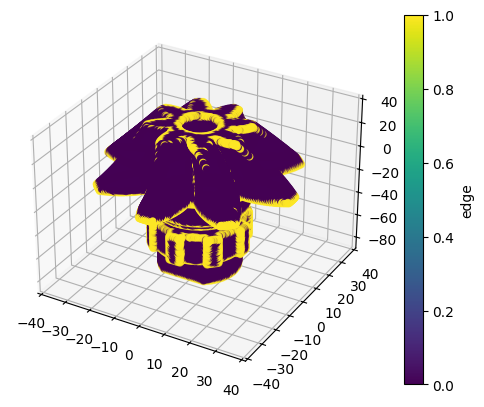

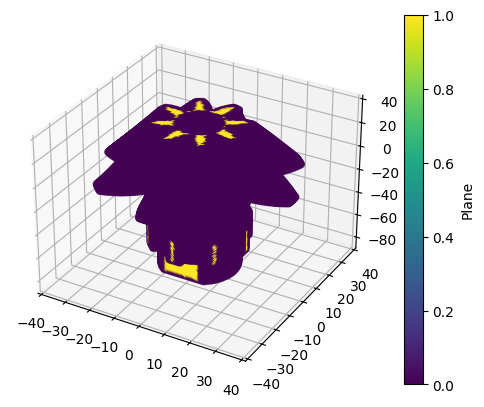

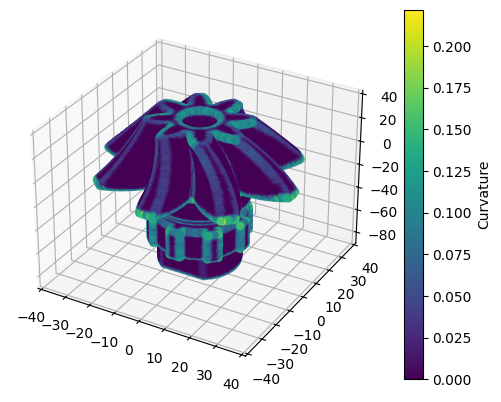

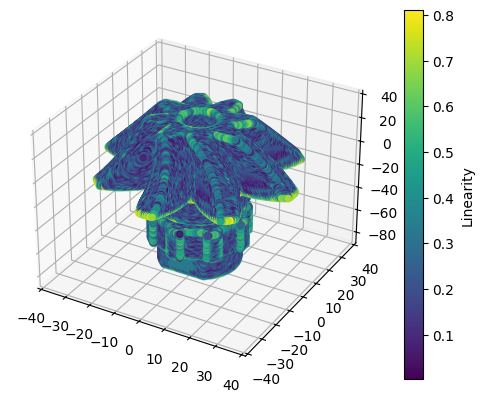

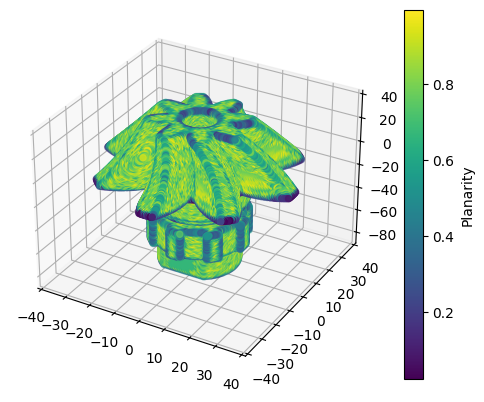

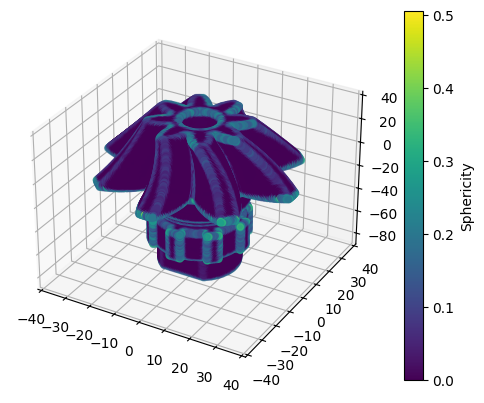

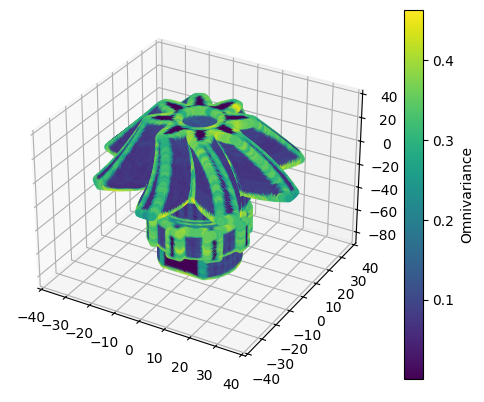

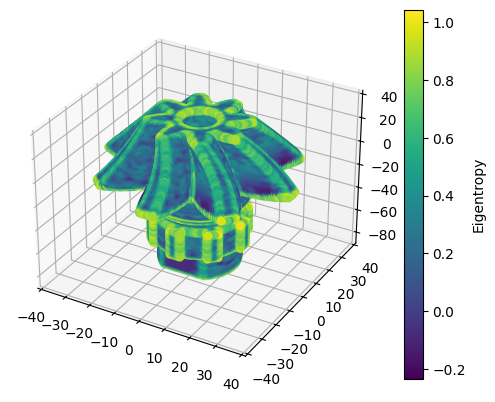

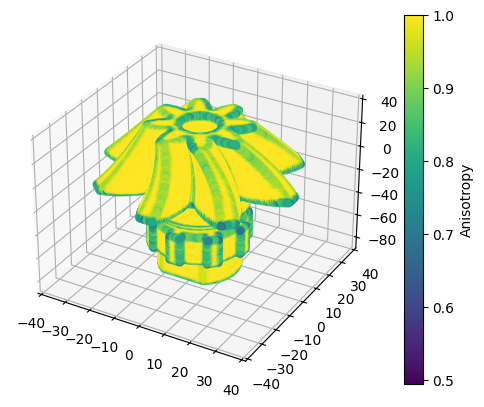

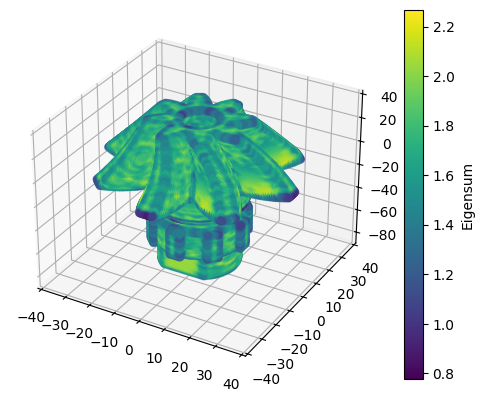

array([[  8.        , -11.299736  , -61.746037  , ...,   0.86948376,
          0.80665266,   1.31174484],
       [  8.        , -11.299736  , -81.378036  , ...,   0.87182125,
          0.80667913,   1.3170611 ],
       [  9.831433  ,  -9.748177  , -81.378036  , ...,   0.70315323,
          0.84073092,   1.51981033],
       ...,
       [-13.012978  ,   8.022108  , -58.656708  , ...,   0.36975469,
          0.97943744,   1.68497384],
       [  5.086076  ,   5.416768  ,  20.002502  , ...,   0.41873808,
          0.99741261,   1.49023698],
       [ -7.440031  ,  -0.171093  ,  21.618855  , ...,   0.16490016,
          0.99591281,   1.85434064]])

In [54]:
path = "C:/Users/aagaa/Documents/GitHub/R-D/Drawings/STL/test.xyz"
path = "C:/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/dataset/SelfGeneratedClouds/bevel_gear.xyz"
#path = "C:/Users/aagaa/Documents/GitHub/R-D/Code/Leihui Code/dataset/scanning_repository/bunny.xyz"
Get_variables(path, k=20,plot="yes", edge_k=10,edge_thresh=0.06)
#Scalar_fields(path)
#Edge_and_Plane(path)